In [1]:
import torch
from PIL import Image,ImageDraw
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import cv2
import math

In [2]:
img = cv2.imread('specimens.png')

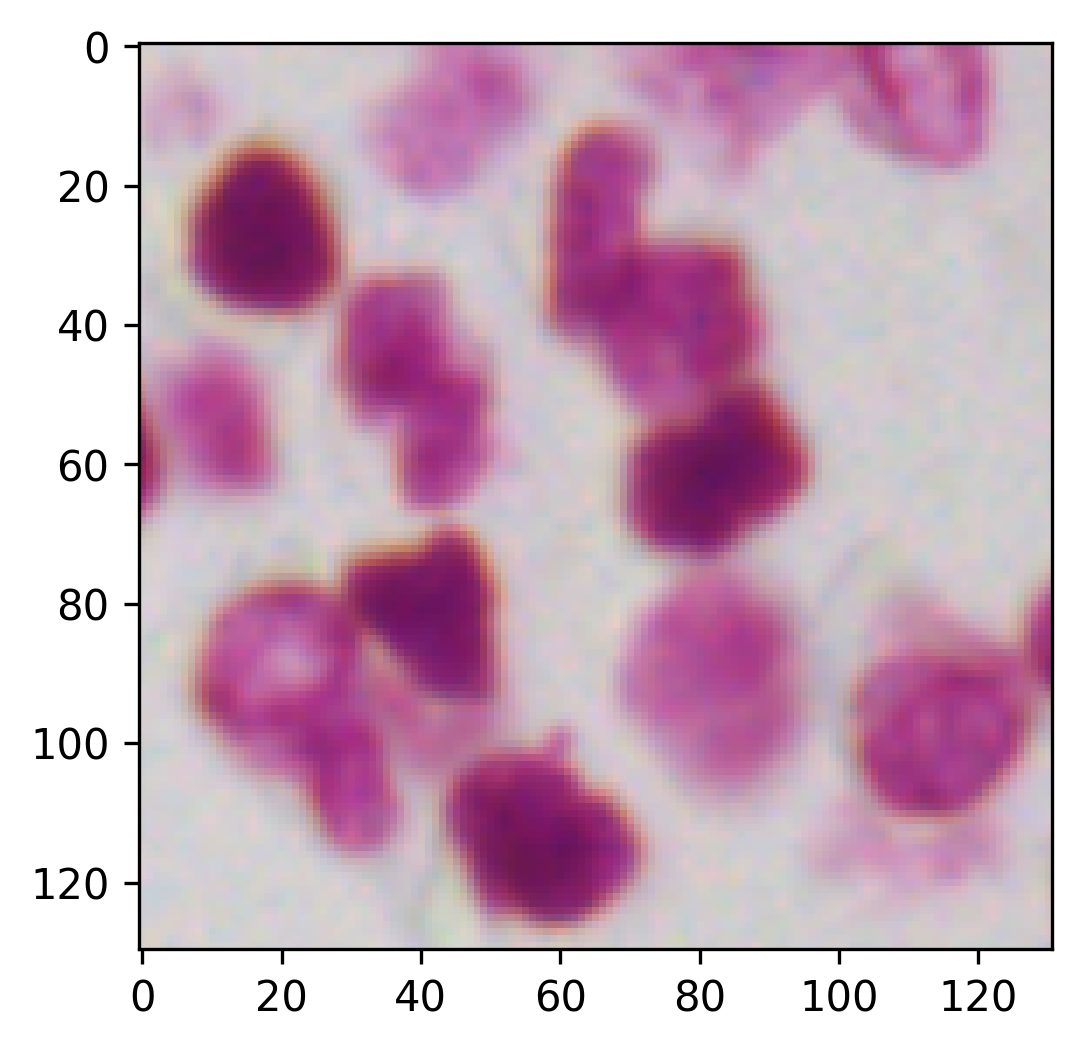

In [3]:
plt.rcParams['figure.dpi'] = 300
plt.imshow(img)

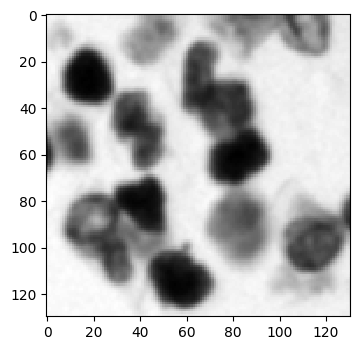

In [4]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.rcParams['figure.dpi'] = 100
plt.imshow(gray,cmap = 'gray')


(Text(0.5,1,'sobely'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

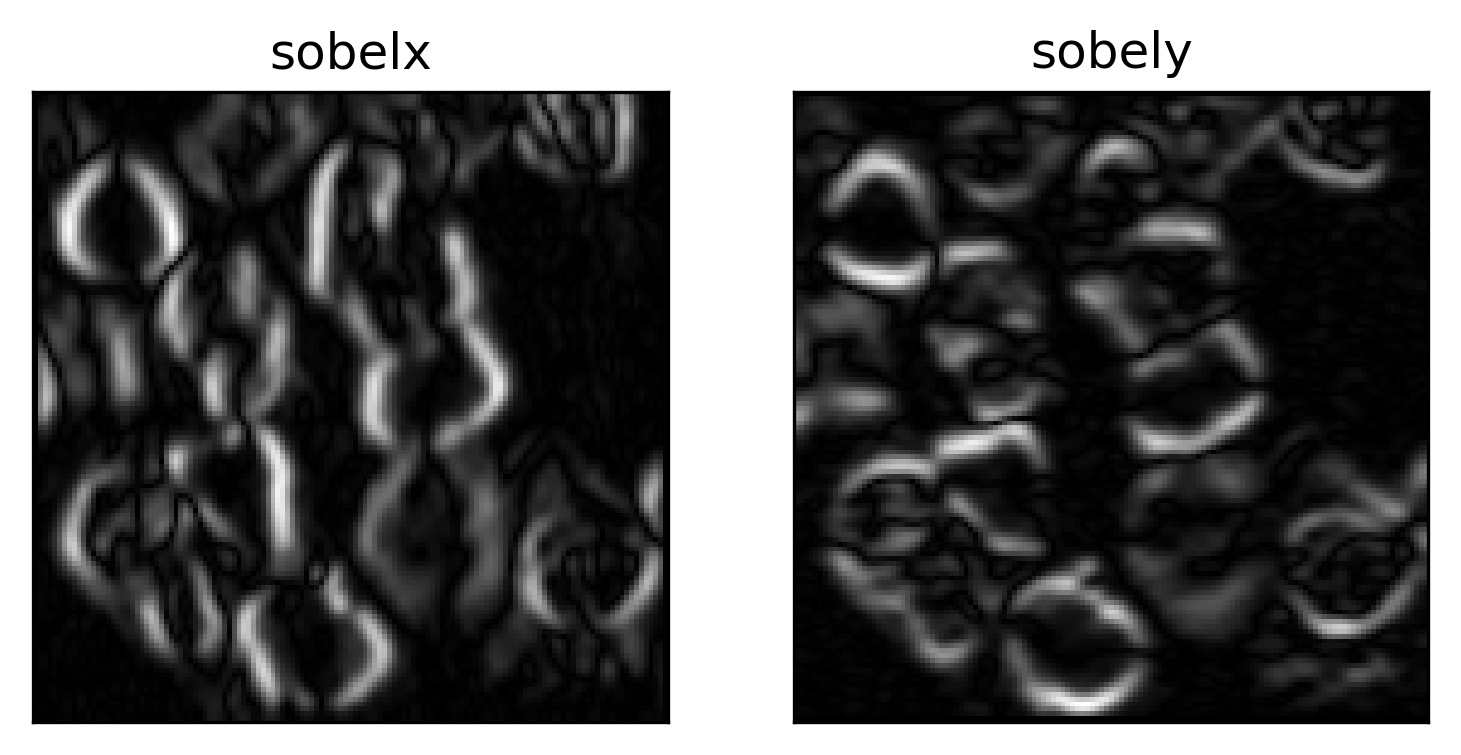

In [5]:
sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=5)
plt.rcParams['figure.dpi'] = 300
plt.subplot(1,2,1),plt.imshow( np.absolute(sobelx),cmap='gray')
plt.title('sobelx'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow( np.absolute(sobely),cmap='gray')
plt.title('sobely'), plt.xticks([]), plt.yticks([])

In [6]:
magni,angle = cv2.cartToPolar(sobelx,sobely)

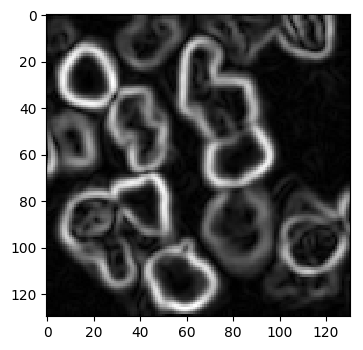

In [7]:
plt.rcParams['figure.dpi'] = 100
plt.imshow(magni,cmap = 'gray')

In [82]:
h,w = magni.shape
temp_mean = magni.mean()
magni.max()

4103.2019204518801

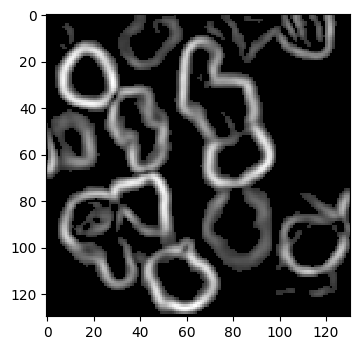

In [89]:
th_magni = np.copy(magni)
th_magni[th_magni<800] = 0
plt.rcParams['figure.dpi'] = 100
plt.imshow(th_magni,cmap = 'gray')

In [9]:
def default_weight(*args):
    return 1
def gauss_weight(y,x,center_y,center_x,sigma):
    s = 2*(sigma)**2
    index = -1*((x-center_x)**2+(y-center_y)**2)/s
    weight = math.exp(index)/(s*math.pi)
    return weight

In [10]:
delta = 30*math.pi/180

def voting_area(y,x,rmin=33,rmax=66,d=delta,weight=default_weight):
    init_area = np.zeros_like(magni)
    orient = (angle[y][x]+math.pi)%(2*math.pi)
    center_y = math.floor(y+((rmin+rmax)/2)*math.sin(orient))
    center_x = math.floor(x+((rmin+rmax)/2)*math.cos(orient))
    
    
    x_low = max(x-rmax,0)
    x_high = min(x+rmax,w)
    y_low = max(y-rmax,0)
    y_high = min(y+rmax,h)
    for i in range(x_low,x_high):
        for j in range(y_low,y_high):
            dist = (i-x)**2+(j-y)**2
            if dist > rmin**2 and dist < rmax**2:
                vec_angle = math.atan2(j-y,i-x) #atan2 return radians from -pi to pi
                if vec_angle <0 :
                    vec_angle += math.pi*2
                angle_diff = abs(vec_angle-orient)
                if  abs(vec_angle-orient)<= d  or abs(vec_angle-orient) >= 2*math.pi-d:
                    init_area[j][i] = 1*weight(j,i,center_y,center_x,(rmax-rmin)*0.5)
            else:
                continue
    return init_area

In [71]:
def cell_voting_area(y,x):
    return voting_area(y,x,rmin=5,rmax=15,weight=gauss_weight)

In [72]:
print(h,w)
print(temp_mean)

130 131
847.468614006


In [73]:
result = []
for i in range(w):
    for j in range(h):
        if magni[j][i] > temp_mean+200:
            result.append(cell_voting_area(j,i)*magni[j][i])

In [ ]:
temp_max = result[0].max()
result[0]
    

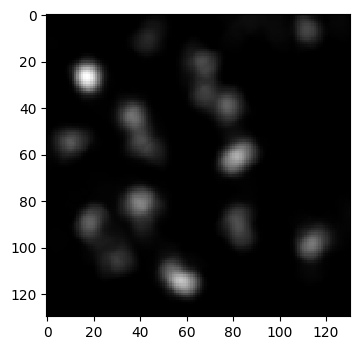

In [75]:
init_map = np.copy(result[0])
for i in range(1,len(result)):
    init_map += result[i]
plt.rcParams['figure.dpi'] = 100
plt.imshow(init_map,cmap = 'gray')

In [76]:
init_map.max()

5856.8046315559222

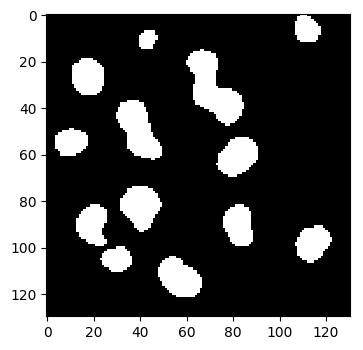

In [103]:
seed_thr = init_map.max()*0.1
test_seed = np.copy(init_map)
test_seed[test_seed<seed_thr] = 0
test_seed[test_seed>=seed_thr] = 1
plt.rcParams['figure.dpi'] = 100
plt.imshow(test_seed,cmap = 'gray')

In [135]:
seed_list = []
for i in range(w):
    for j in range(h):
        if test_seed[j][i] > 0:
            count = math.floor(math.sqrt(init_map[j][i]/100))
            for t in range(count):
                seed_list.append([j,i])
        else:
            continue

In [136]:
len(seed_list)

8038

In [137]:
 from sklearn.cluster import MeanShift

In [152]:
X = np.array(seed_list)
clusterling = MeanShift(bandwidth=7,n_jobs=1).fit(X)

In [153]:
final_seed = clusterling.cluster_centers_

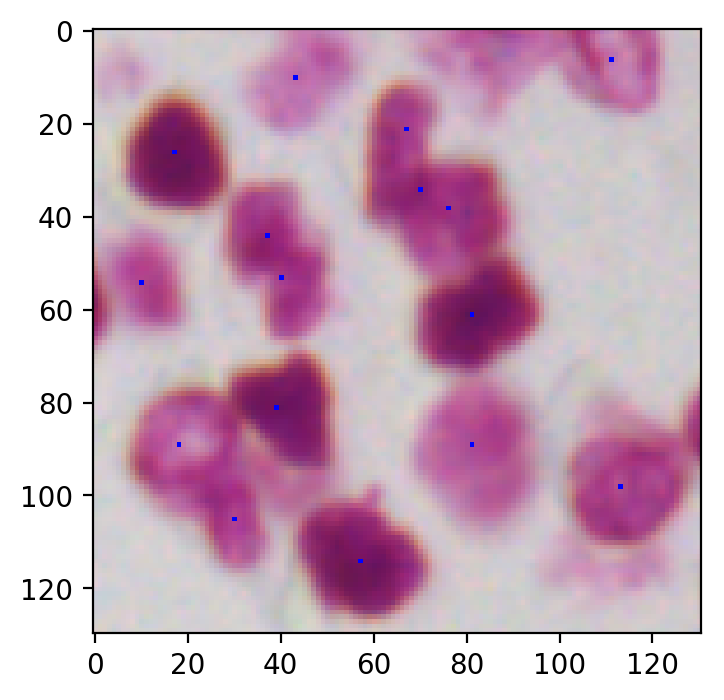

In [154]:
show_img = cv2.imread('specimens.png')
for i in range(len(final_seed)):
    coord = final_seed[i]
    y = math.floor(coord[0])
    x = math.floor(coord[1])
    show_img[y][x] = [0,0,255]
plt.rcParams['figure.dpi'] = 200
plt.imshow(show_img)

In [155]:
len(final_seed)

16